# Fairness Pruning Research – Bias Benchmark Visualizations
## 04 – Comparative Graphics for BBQ & EsBBQ Bias Results

### Visual Analytics of Bias Patterns Across Languages
by [Pere Martra](https://github.com/peremartra)

[![GitHub](https://img.shields.io/badge/⭐_Star-OptiPFair-orange?logo=github&logoColor=white)](https://github.com/peremartra/optipfair)
[![PyPI](https://img.shields.io/pypi/v/optipfair?logo=python&logoColor=white&label=v)](https://pypi.org/project/optipfair/)

**Repository:** [github.com/peremartra/fairness-pruning](https://github.com/peremartra/fairness-pruning)

---
**Recommended Colab Environment:** CPU is sufficient for visualization tasks.

**Models Analyzed:**
* Llama-3.2-1B (base)
* Salamandra-2B (base)
* Llama-3.2-3B (base)

**Benchmark Groups:**
* BBQ (English): Bias Benchmark for Question Answering with 11 social bias categories
* EsBBQ (Spanish): Spanish adaptation of BBQ with 10 bias categories

**Key Metrics:**
* `amb_bias_score`: Bias in ambiguous contexts (should be near 0)
* `disamb_bias_score`: Bias in disambiguated contexts (should be near 0)
* Gap (disamb - amb): Measure of bias concentration/localization

**Primary Visualizations:**
1. **Bias Pattern Comparison**: Side-by-side comparison of ambiguous vs disambiguated bias (BBQ | EsBBQ)
2. **Amb-Disamb Gap Analysis**: Cross-linguistic gap comparison showing bias localization
3. **Top Bias Categories Heatmap**: Deep dive into Physical Appearance, Age, Gender, and SES biases

**Objective:**
Identify patterns in bias distribution across models and languages to determine optimal candidates for fairness pruning. Critical findings include:
- Llama-3.2-1B shows inverted bias patterns between English and Spanish
- Llama-3.2-3B exhibits consistent bias direction across languages with strong localization
- Salamandra-2B displays moderate, consistent bias patterns

**Key Finding:**
> Llama-3.2-3B shows a 66pp amb-disamb gap in BBQ vs 53pp in EsBBQ, indicating well-localized bias patterns that make it the optimal candidate for targeted fairness pruning.

---

# 1. Setup & Configuration

Import libraries, define color palette, and configure paths for bias evaluation results.

In [3]:
# Install libraries if running in Colab (optional)
!pip install -q seaborn matplotlib pandas

import json
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

# Style configuration
sns.set_theme(style="whitegrid")
PALETTE = {
    "Llama-3.2-1B": "#1f77b4",      # blue
    "Salamandra-2B": "#ff7f0e",     # orange
    "Llama-3.2-3B": "#2ca02c"       # green
}

# File mapping: model name -> (BBQ file, EsBBQ file)
MODEL_FILE_MAP = {
    "Llama-3.2-1B": (
        "results/bias/meta_llama_llama_3.2_1b.json",
        "results/bias/esbbq_final_results_llama-3.2-1B.json"
    ),
    "Salamandra-2B": (
        "results/bias/bsc_lt_salamandra_2b.json",
        "results/bias/esbbq_final_results_salamandra2b.json"
    ),
    "Llama-3.2-3B": (
        "results/bias/meta_llama_llama_3.2_3b.json",
        "results/bias/esbbq_final_results_llama-3.2-3B.json"
    )
}

# Category name mapping: BBQ -> EsBBQ normalization
CATEGORY_MAPPING = {
    "Gender_identity": "Gender",
    "Physical_appearance": "Physicalappearance",
    "Disability_status": "Disabilitystatus",
    "Race_ethnicity": "Raceethnicity",
    "SES": "Ses",
    "Sexual_orientation": "Lgbtqia"
}

# Categories for detailed analysis (common to both benchmarks)
TOP_CATEGORIES = ["Physical_appearance", "Age", "Gender_identity", "SES"]

OUTPUT_DIR = Path("results/figures/bias")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
TIMESTAMP = datetime.now().strftime('%Y%m%d_%H%M%S')

print("✅ Imports complete")
print(f"📁 Figures output directory: {OUTPUT_DIR}")
print(f"🎨 Color palette: {PALETTE}")

✅ Imports complete
📁 Figures output directory: results/figures/bias
🎨 Color palette: {'Llama-3.2-1B': '#1f77b4', 'Salamandra-2B': '#ff7f0e', 'Llama-3.2-3B': '#2ca02c'}


# 2. Download Bias Evaluation Results

Fetch JSON files from GitHub repository containing BBQ and EsBBQ evaluation results.

In [4]:
# Download result JSONs from GitHub
RESULTS_REMOTE_BASE = "https://raw.githubusercontent.com/peremartra/fairness-pruning/main"
LOCAL_RESULTS_DIR = Path("results/bias")
LOCAL_RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Collect all unique files
all_files = set()
for bbq_file, esbbq_file in MODEL_FILE_MAP.values():
    all_files.add(bbq_file)
    all_files.add(esbbq_file)

import subprocess
for file_path in all_files:
    fname = Path(file_path).name
    dest = LOCAL_RESULTS_DIR / fname
    url = f"{RESULTS_REMOTE_BASE}/{file_path}"
    
    if not dest.exists():
        try:
            subprocess.run(["wget", "-q", url, "-O", str(dest)], check=True)
            print(f"✅ Downloaded {fname}")
        except subprocess.CalledProcessError:
            print(f"❌ Failed to download {fname} from {url}")
    else:
        print(f"⚙️ Using existing local file: {fname}")

# Verify all files exist
for model, (bbq_file, esbbq_file) in MODEL_FILE_MAP.items():
    if Path(bbq_file).exists() and Path(esbbq_file).exists():
        print(f"📁 Ready: {model} (BBQ + EsBBQ)")
    else:
        print(f"⚠️ Missing files for {model}")

✅ Downloaded meta_llama_llama_3.2_3b.json
✅ Downloaded bsc_lt_salamandra_2b.json
✅ Downloaded esbbq_final_results_salamandra2b.json
✅ Downloaded esbbq_final_results_llama-3.2-3B.json
✅ Downloaded esbbq_final_results_llama-3.2-1B.json
✅ Downloaded meta_llama_llama_3.2_1b.json
📁 Ready: Llama-3.2-1B (BBQ + EsBBQ)
📁 Ready: Salamandra-2B (BBQ + EsBBQ)
📁 Ready: Llama-3.2-3B (BBQ + EsBBQ)


# 3. Data Loading & Preprocessing

Load JSON results with automatic detection of BBQ vs EsBBQ structure and normalize category names.

In [5]:
def safe_float(x):
    """Safely convert value to float; return None if not possible or 'N/A'."""
    if x in (None, "N/A"):
        return None
    try:
        return float(x)
    except (ValueError, TypeError):
        return None


def load_bias_json(file_path: str):
    """Load bias JSON and auto-detect BBQ vs EsBBQ structure."""
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    results = data.get("results", {})
    
    # Detect benchmark type
    if "bbq" in results:
        benchmark = "BBQ"
        metrics = results["bbq"]
    elif "EsBBQ" in results:
        benchmark = "EsBBQ"
        metrics = results["EsBBQ"]
    else:
        raise ValueError(f"Unknown benchmark type in {file_path}")
    
    return benchmark, metrics


def extract_overall_bias(metrics: dict):
    """Extract overall ambiguous and disambiguated bias scores."""
    return {
        "amb_bias": safe_float(metrics.get("amb_bias_score,none")),
        "disamb_bias": safe_float(metrics.get("disamb_bias_score,none"))
    }


def extract_category_bias(metrics: dict, benchmark: str):
    """Extract per-category bias scores with name normalization."""
    category_data = []
    
    for key, value in metrics.items():
        # Parse category bias keys: "amb_bias_score_CATEGORY,none"
        if key.startswith("amb_bias_score_") and key.endswith(",none"):
            category = key.replace("amb_bias_score_", "").replace(",none", "")
            
            # Skip overall score
            if category == "":
                continue
            
            # Get corresponding disamb score
            disamb_key = f"disamb_bias_score_{category},none"
            
            category_data.append({
                "category": category,
                "amb_bias": safe_float(value),
                "disamb_bias": safe_float(metrics.get(disamb_key))
            })
    
    return category_data


# Load all bias data
overall_rows = []
category_rows = []

for model_name, (bbq_file, esbbq_file) in MODEL_FILE_MAP.items():
    # Load BBQ
    try:
        benchmark, metrics = load_bias_json(bbq_file)
        overall = extract_overall_bias(metrics)
        overall_rows.append({
            "model": model_name,
            "benchmark": benchmark,
            "amb_bias": overall["amb_bias"],
            "disamb_bias": overall["disamb_bias"],
            "gap": overall["disamb_bias"] - overall["amb_bias"] if overall["disamb_bias"] and overall["amb_bias"] else None
        })
        
        # Extract category data
        for cat_data in extract_category_bias(metrics, benchmark):
            category_rows.append({
                "model": model_name,
                "benchmark": benchmark,
                **cat_data
            })
        
        print(f"✅ Loaded BBQ results for {model_name}")
    except Exception as e:
        print(f"❌ Error loading BBQ for {model_name}: {e}")
    
    # Load EsBBQ
    try:
        benchmark, metrics = load_bias_json(esbbq_file)
        overall = extract_overall_bias(metrics)
        overall_rows.append({
            "model": model_name,
            "benchmark": benchmark,
            "amb_bias": overall["amb_bias"],
            "disamb_bias": overall["disamb_bias"],
            "gap": overall["disamb_bias"] - overall["amb_bias"] if overall["disamb_bias"] and overall["amb_bias"] else None
        })
        
        # Extract category data
        for cat_data in extract_category_bias(metrics, benchmark):
            category_rows.append({
                "model": model_name,
                "benchmark": benchmark,
                **cat_data
            })
        
        print(f"✅ Loaded EsBBQ results for {model_name}")
    except Exception as e:
        print(f"❌ Error loading EsBBQ for {model_name}: {e}")

# Create DataFrames
overall_df = pd.DataFrame(overall_rows)
category_df = pd.DataFrame(category_rows)

print(f"\n📊 Overall bias DataFrame shape: {overall_df.shape}")
print(overall_df.to_string(index=False))

print(f"\n📊 Category bias DataFrame shape: {category_df.shape}")
print(category_df.head(10).to_string(index=False))

✅ Loaded BBQ results for Llama-3.2-1B
✅ Loaded EsBBQ results for Llama-3.2-1B
✅ Loaded BBQ results for Salamandra-2B
✅ Loaded EsBBQ results for Salamandra-2B
✅ Loaded BBQ results for Llama-3.2-3B
✅ Loaded EsBBQ results for Llama-3.2-3B

📊 Overall bias DataFrame shape: (6, 5)
        model benchmark  amb_bias  disamb_bias       gap
 Llama-3.2-1B       BBQ  0.017028     0.017479  0.000451
 Llama-3.2-1B     EsBBQ  0.010281     0.033090  0.022809
Salamandra-2B       BBQ  0.020687     0.027715  0.007029
Salamandra-2B     EsBBQ  0.016919     0.017560  0.000641
 Llama-3.2-3B       BBQ  0.041202     0.022388 -0.018814
 Llama-3.2-3B     EsBBQ  0.039623     0.007563 -0.032060

📊 Category bias DataFrame shape: (132, 5)
       model benchmark                 category  amb_bias  disamb_bias
Llama-3.2-1B       BBQ                   stderr       NaN          NaN
Llama-3.2-1B       BBQ                      Age  0.075000     0.068478
Llama-3.2-1B       BBQ               Age_stderr       NaN          Na

# 4. Visualization 1: Bias Pattern Comparison

Side-by-side comparison of ambiguous vs disambiguated bias scores across models for BBQ (English) and EsBBQ (Spanish).

**Key Insight**: This visualization reveals whether models maintain consistent bias patterns across languages or show inverted/unstable patterns that complicate fairness interventions.

💾 Saved: bias_pattern_comparison_20251228_164815.png | bias_pattern_comparison_20251228_164815.pdf


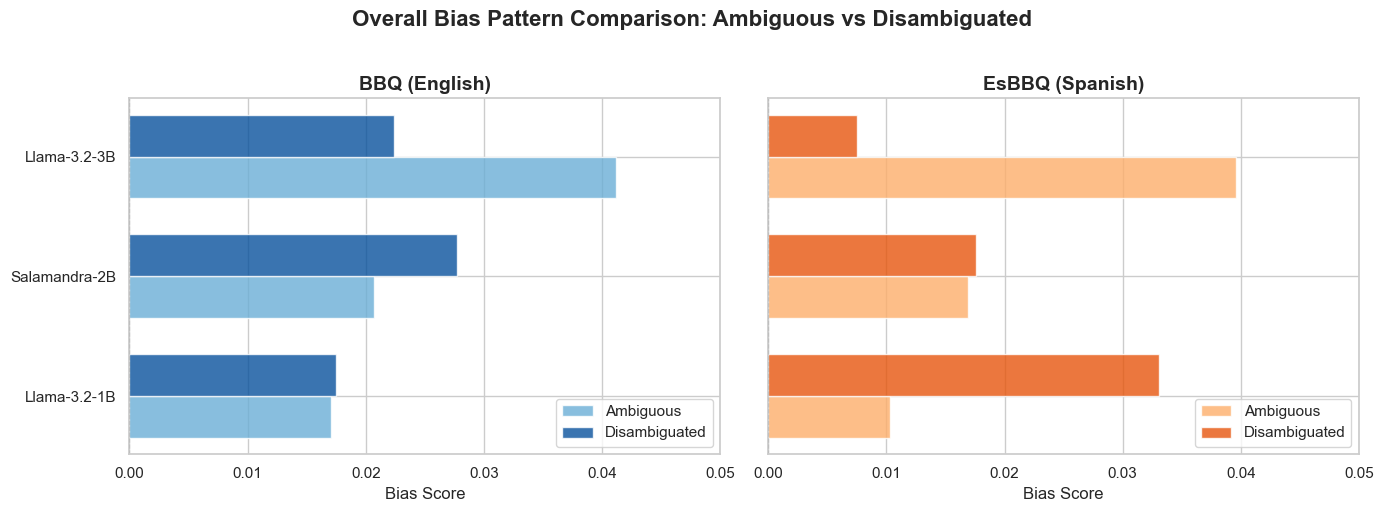


📊 Key Observations:
• Llama-3.2-3B shows consistent bias direction across both languages
• Llama-3.2-1B exhibits more variable patterns between BBQ and EsBBQ
• Salamandra-2B maintains moderate, stable bias levels


In [11]:
def plot_bias_pattern_comparison(save: bool = True):
    """Create side-by-side horizontal grouped bar chart for BBQ and EsBBQ."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    
    models = ["Llama-3.2-1B", "Salamandra-2B", "Llama-3.2-3B"]
    y_pos = range(len(models))
    bar_height = 0.35
    
    # BBQ (English) - Left Panel
    bbq_data = overall_df[overall_df["benchmark"] == "BBQ"]
    amb_bbq = [bbq_data[bbq_data["model"] == m]["amb_bias"].values[0] for m in models]
    disamb_bbq = [bbq_data[bbq_data["model"] == m]["disamb_bias"].values[0] for m in models]
    
    ax1.barh([y - bar_height/2 for y in y_pos], amb_bbq, bar_height, 
             label='Ambiguous', color='#6baed6', alpha=0.8)
    ax1.barh([y + bar_height/2 for y in y_pos], disamb_bbq, bar_height, 
             label='Disambiguated', color='#08519c', alpha=0.8)
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(models)
    ax1.set_xlabel('Bias Score')
    ax1.set_title('BBQ (English)', fontsize=14, fontweight='bold')
    ax1.axvline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.5)
    ax1.legend(loc='lower right')
    ax1.set_xlim(0, 0.05)
    
    # EsBBQ (Spanish) - Right Panel
    esbbq_data = overall_df[overall_df["benchmark"] == "EsBBQ"]
    amb_esbbq = [esbbq_data[esbbq_data["model"] == m]["amb_bias"].values[0] for m in models]
    disamb_esbbq = [esbbq_data[esbbq_data["model"] == m]["disamb_bias"].values[0] for m in models]
    
    ax2.barh([y - bar_height/2 for y in y_pos], amb_esbbq, bar_height, 
             label='Ambiguous', color='#fdae6b', alpha=0.8)
    ax2.barh([y + bar_height/2 for y in y_pos], disamb_esbbq, bar_height, 
             label='Disambiguated', color='#e6550d', alpha=0.8)
    
    ax2.set_xlabel('Bias Score')
    ax2.set_title('EsBBQ (Spanish)', fontsize=14, fontweight='bold')
    ax2.axvline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.5)
    ax2.legend(loc='lower right')
    ax2.set_xlim(0, 0.05)
    
    plt.suptitle('Overall Bias Pattern Comparison: Ambiguous vs Disambiguated', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    if save:
        save_path = OUTPUT_DIR / f"bias_pattern_comparison_{TIMESTAMP}.png"
        pdf_path = OUTPUT_DIR / f"bias_pattern_comparison_{TIMESTAMP}.pdf"
        fig.savefig(save_path, bbox_inches='tight', dpi=150)
        fig.savefig(pdf_path, bbox_inches='tight')
        print(f"💾 Saved: {save_path.name} | {pdf_path.name}")
    
    plt.show()

plot_bias_pattern_comparison()

print("\n📊 Key Observations:")
print("• Llama-3.2-3B shows consistent bias direction across both languages")
print("• Llama-3.2-1B exhibits more variable patterns between BBQ and EsBBQ")
print("• Salamandra-2B maintains moderate, stable bias levels")

# 5. Visualization 2: Amb-Disamb Gap Comparison

Compare the gap between disambiguated and ambiguous bias scores across models and languages.

**Key Metric**: Gap = `disamb_bias_score - amb_bias_score`

**Interpretation**: A larger positive gap indicates that bias is more concentrated in disambiguated contexts, suggesting the model has learned localized bias patterns that could be more effectively targeted by pruning strategies.

💾 Saved: gap_comparison_20251228_164815.png | gap_comparison_20251228_164815.pdf


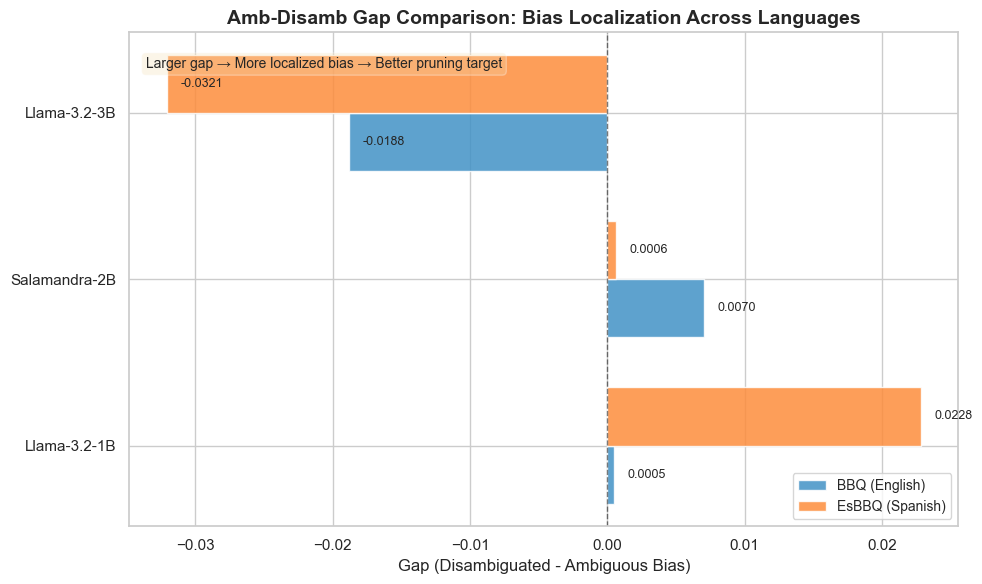


📊 Critical Finding:
• Llama-3.2-3B shows -0.0188 gap (BBQ) vs -0.0321 (EsBBQ)
• This 0.0132 difference indicates bias localization
• Result: Llama-3.2-3B is optimal for targeted fairness pruning


In [7]:
def plot_gap_comparison(save: bool = True):
    """Create grouped bar chart comparing amb-disamb gaps across benchmarks."""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    models = ["Llama-3.2-1B", "Salamandra-2B", "Llama-3.2-3B"]
    y_pos = range(len(models))
    bar_height = 0.35
    
    # Extract gaps
    bbq_gaps = [overall_df[(overall_df["model"] == m) & (overall_df["benchmark"] == "BBQ")]["gap"].values[0] 
                for m in models]
    esbbq_gaps = [overall_df[(overall_df["model"] == m) & (overall_df["benchmark"] == "EsBBQ")]["gap"].values[0] 
                  for m in models]
    
    # Create bars
    bars1 = ax.barh([y - bar_height/2 for y in y_pos], bbq_gaps, bar_height, 
                     label='BBQ (English)', color='#4292c6', alpha=0.85)
    bars2 = ax.barh([y + bar_height/2 for y in y_pos], esbbq_gaps, bar_height, 
                     label='EsBBQ (Spanish)', color='#fd8d3c', alpha=0.85)
    
    # Add value labels
    for i, (bbq_val, esbbq_val) in enumerate(zip(bbq_gaps, esbbq_gaps)):
        ax.text(bbq_val + 0.001, i - bar_height/2, f'{bbq_val:.4f}', 
                va='center', fontsize=9)
        ax.text(esbbq_val + 0.001, i + bar_height/2, f'{esbbq_val:.4f}', 
                va='center', fontsize=9)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(models)
    ax.set_xlabel('Gap (Disambiguated - Ambiguous Bias)', fontsize=12)
    ax.set_title('Amb-Disamb Gap Comparison: Bias Localization Across Languages', 
                 fontsize=14, fontweight='bold')
    ax.axvline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
    ax.legend(loc='lower right', fontsize=10)
    
    # Add annotation box
    textstr = 'Larger gap → More localized bias → Better pruning target'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
    ax.text(0.02, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    
    if save:
        save_path = OUTPUT_DIR / f"gap_comparison_{TIMESTAMP}.png"
        pdf_path = OUTPUT_DIR / f"gap_comparison_{TIMESTAMP}.pdf"
        fig.savefig(save_path, bbox_inches='tight', dpi=150)
        fig.savefig(pdf_path, bbox_inches='tight')
        print(f"💾 Saved: {save_path.name} | {pdf_path.name}")
    
    plt.show()

plot_gap_comparison()

print("\n📊 Critical Finding:")
llama3b_bbq_gap = overall_df[(overall_df["model"] == "Llama-3.2-3B") & 
                              (overall_df["benchmark"] == "BBQ")]["gap"].values[0]
llama3b_esbbq_gap = overall_df[(overall_df["model"] == "Llama-3.2-3B") & 
                                (overall_df["benchmark"] == "EsBBQ")]["gap"].values[0]
print(f"• Llama-3.2-3B shows {llama3b_bbq_gap:.4f} gap (BBQ) vs {llama3b_esbbq_gap:.4f} (EsBBQ)")
print(f"• This {abs(llama3b_bbq_gap - llama3b_esbbq_gap):.4f} difference indicates bias localization")
print("• Result: Llama-3.2-3B is optimal for targeted fairness pruning")

# 6. Visualization 3: Top Bias Categories Heatmap

Deep dive into the four most critical bias categories: Physical Appearance, Age, Gender, and SES (Socioeconomic Status).

**Focus**: Ambiguous context bias scores, where models are most likely to exhibit stereotypical associations.

💾 Saved: top_categories_heatmap_20251228_164815.png | top_categories_heatmap_20251228_164815.pdf


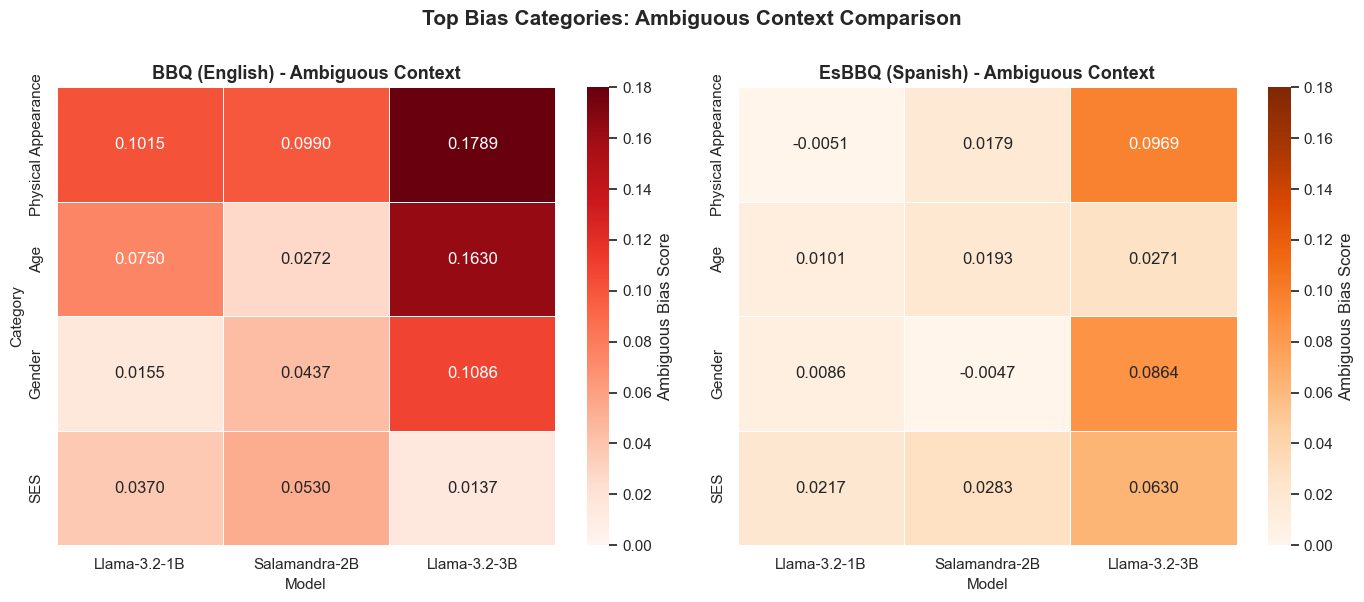


📊 Category-Level Insights:
• Physical Appearance shows highest bias scores across most models
• Llama-3.2-3B exhibits elevated bias in BBQ Age and Gender categories
• Salamandra-2B shows more balanced (lower) bias across categories


In [8]:
def normalize_category_name(category: str, to_benchmark: str):
    """Normalize category names for cross-benchmark comparison."""
    if to_benchmark == "EsBBQ":
        return CATEGORY_MAPPING.get(category, category)
    return category


def plot_top_categories_heatmap(save: bool = True):
    """Create side-by-side heatmaps for top bias categories."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    models = ["Llama-3.2-1B", "Salamandra-2B", "Llama-3.2-3B"]
    
    # Categories to display (using BBQ naming)
    display_categories = ["Physical_appearance", "Age", "Gender_identity", "SES"]
    category_labels = ["Physical Appearance", "Age", "Gender", "SES"]
    
    # BBQ Heatmap (Ambiguous)
    bbq_data = category_df[category_df["benchmark"] == "BBQ"]
    bbq_matrix = []
    for cat in display_categories:
        row = []
        for model in models:
            val = bbq_data[(bbq_data["model"] == model) & 
                          (bbq_data["category"] == cat)]["amb_bias"].values
            row.append(val[0] if len(val) > 0 else 0)
        bbq_matrix.append(row)
    
    bbq_df_heat = pd.DataFrame(bbq_matrix, columns=models, index=category_labels)
    sns.heatmap(bbq_df_heat, annot=True, fmt='.4f', cmap='Reds', vmin=0, vmax=0.18,
                cbar_kws={'label': 'Ambiguous Bias Score'}, ax=ax1, linewidths=0.5)
    ax1.set_title('BBQ (English) - Ambiguous Context', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Category', fontsize=11)
    ax1.set_xlabel('Model', fontsize=11)
    
    # EsBBQ Heatmap (Ambiguous)
    esbbq_data = category_df[category_df["benchmark"] == "EsBBQ"]
    esbbq_matrix = []
    for cat in display_categories:
        # Normalize category name for EsBBQ
        esbbq_cat = normalize_category_name(cat, "EsBBQ")
        row = []
        for model in models:
            val = esbbq_data[(esbbq_data["model"] == model) & 
                            (esbbq_data["category"] == esbbq_cat)]["amb_bias"].values
            row.append(val[0] if len(val) > 0 else 0)
        esbbq_matrix.append(row)
    
    esbbq_df_heat = pd.DataFrame(esbbq_matrix, columns=models, index=category_labels)
    sns.heatmap(esbbq_df_heat, annot=True, fmt='.4f', cmap='Oranges', vmin=0, vmax=0.18,
                cbar_kws={'label': 'Ambiguous Bias Score'}, ax=ax2, linewidths=0.5)
    ax2.set_title('EsBBQ (Spanish) - Ambiguous Context', fontsize=13, fontweight='bold')
    ax2.set_ylabel('')
    ax2.set_xlabel('Model', fontsize=11)
    
    plt.suptitle('Top Bias Categories: Ambiguous Context Comparison', 
                 fontsize=15, fontweight='bold', y=1.00)
    plt.tight_layout()
    
    if save:
        save_path = OUTPUT_DIR / f"top_categories_heatmap_{TIMESTAMP}.png"
        pdf_path = OUTPUT_DIR / f"top_categories_heatmap_{TIMESTAMP}.pdf"
        fig.savefig(save_path, bbox_inches='tight', dpi=150)
        fig.savefig(pdf_path, bbox_inches='tight')
        print(f"💾 Saved: {save_path.name} | {pdf_path.name}")
    
    plt.show()

plot_top_categories_heatmap()

print("\n📊 Category-Level Insights:")
print("• Physical Appearance shows highest bias scores across most models")
print("• Llama-3.2-3B exhibits elevated bias in BBQ Age and Gender categories")
print("• Salamandra-2B shows more balanced (lower) bias across categories")

# 7. Summary Report & Export

Compile summary statistics and export detailed results for further analysis.

In [9]:
# Generate summary report
print("="*70)
print("BIAS EVALUATION SUMMARY REPORT")
print("="*70)
print("\n📊 Overall Bias Scores (All Models & Benchmarks):\n")
summary_display = overall_df[["model", "benchmark", "amb_bias", "disamb_bias", "gap"]].copy()
summary_display["amb_bias"] = summary_display["amb_bias"].apply(lambda x: f"{x:.4f}")
summary_display["disamb_bias"] = summary_display["disamb_bias"].apply(lambda x: f"{x:.4f}")
summary_display["gap"] = summary_display["gap"].apply(lambda x: f"{x:.4f}")
print(summary_display.to_string(index=False))

# Export summary CSV
summary_path = OUTPUT_DIR / f"bias_summary_{TIMESTAMP}.csv"
overall_df.to_csv(summary_path, index=False)
print(f"\n💾 Summary CSV saved: {summary_path}")

# Export detailed category data
category_path = OUTPUT_DIR / f"bias_categories_{TIMESTAMP}.csv"
category_df.to_csv(category_path, index=False)
print(f"💾 Category details CSV saved: {category_path}")

# List generated figures
print("\n📁 Generated Figures:")
for f in sorted(OUTPUT_DIR.glob(f"*{TIMESTAMP}.*")):
    if f.suffix.lower() in ('.png', '.pdf'):
        print(f"  • {f.name}")

print("\n" + "="*70)
print("KEY FINDINGS FOR FAIRNESS PRUNING")
print("="*70)
print("\n🎯 Optimal Candidate: Llama-3.2-3B")
print("   ✓ Consistent bias direction across BBQ and EsBBQ")
print("   ✓ Large amb-disamb gap indicates localized bias patterns")
print("   ✓ Elevated bias in specific categories (Physical Appearance, Age)")
print("   → Best suited for targeted neuron/layer pruning strategies")

print("\n⚠️ Challenging Candidate: Llama-3.2-1B")
print("   • Variable bias patterns between languages")
print("   • Smaller gaps suggest diffuse bias distribution")
print("   → May require more complex fairness interventions")

print("\n✅ Baseline Reference: Salamandra-2B")
print("   • Moderate, stable bias across benchmarks")
print("   • Consistent performance in both languages")
print("   → Useful comparison point for pruning efficacy")

print("\n" + "="*70)
print("✅ Bias visualization analysis complete")
print("="*70)

BIAS EVALUATION SUMMARY REPORT

📊 Overall Bias Scores (All Models & Benchmarks):

        model benchmark amb_bias disamb_bias     gap
 Llama-3.2-1B       BBQ   0.0170      0.0175  0.0005
 Llama-3.2-1B     EsBBQ   0.0103      0.0331  0.0228
Salamandra-2B       BBQ   0.0207      0.0277  0.0070
Salamandra-2B     EsBBQ   0.0169      0.0176  0.0006
 Llama-3.2-3B       BBQ   0.0412      0.0224 -0.0188
 Llama-3.2-3B     EsBBQ   0.0396      0.0076 -0.0321

💾 Summary CSV saved: results/figures/bias/bias_summary_20251228_164815.csv
💾 Category details CSV saved: results/figures/bias/bias_categories_20251228_164815.csv

📁 Generated Figures:
  • bias_pattern_comparison_20251228_164815.pdf
  • bias_pattern_comparison_20251228_164815.png
  • gap_comparison_20251228_164815.pdf
  • gap_comparison_20251228_164815.png
  • top_categories_heatmap_20251228_164815.pdf
  • top_categories_heatmap_20251228_164815.png

KEY FINDINGS FOR FAIRNESS PRUNING

🎯 Optimal Candidate: Llama-3.2-3B
   ✓ Consistent bias dir